In [180]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context("poster")

In [2]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
def gen_shift(d, n):
    """from 1 to n"""
    dds = []

    for i in np.array([1, 2, 480, 960, 1440, 2880]):
        dd = d.shift(i).drop(['str_245'], axis=1)
        cols = dd.columns
        cols = change_col_names(dd, cols, i)
        dd.columns = cols
        dds.append(dd)

    for ddd in dds:
        d = pd.concat([d, ddd])

    return d


def change_col_names(dd, cols, i):
    new_names = []

    for name in dd.columns:
        name += "_{}".format(i)
        new_names.append(name)

    return new_names


def feature_scaling(df):
    scaler = MinMaxScaler()

    df[['trf_count', 'weather_9001', 'weather_9011', 'weather_9002',
        'weather_9012', 'str_245', 'tmp_269']] = scaler.fit_transform(df[['trf_count', 'weather_9001', 'weather_9011', 'weather_9002',
                                                                          'weather_9012', 'str_245', 'tmp_269']])
    return df

In [4]:
df = pd.read_hdf('elite_sen_final.h5', 'table')
df = df.drop(['tmp_211', 'str_172'], axis=1)
df = df.loc['2017-07-01':'2017-08-29']
df['str_245'] = df['str_245'].interpolate()
df['tmp_269'] = df['tmp_269'].interpolate()
df = feature_scaling(df)

# before shfit
X = df.drop('str_245', axis=1)
y = df.str_245
X_train = X.loc[:'2017-08-20']
y_train = y.loc[:'2017-08-20']
X_test = X.loc['2017-08-20':]
y_test = y.loc['2017-08-20':]

# time shift
df = gen_shift(df, 6).groupby(level=0).sum().dropna()
print('With time shift:')

X = df.drop('str_245', axis=1)
y = df.str_245

X_train = X.loc[:'2017-08-20']
y_train = y.loc[:'2017-08-20']

X_test = X.loc['2017-08-20':]
y_test = y.loc['2017-08-20':]


With time shift:


In [5]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
model = Sequential()
model.add(LSTM(16, input_shape=(1, 42), return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=2)
y_pred = model.predict(X_test)


Epoch 1/2
144000/144000 [==============================] - 22s 149us/step - loss: 4.2985e-04
Epoch 2/2
144000/144000 [==============================] - 22s 151us/step - loss: 2.1566e-04


In [6]:
r2 = r2_score(y_test, y_pred)

In [123]:
r2

0.92544838619352143

In [7]:
del [df, X_train, X_test, y_train, model, X, y]

## Plotting

In [8]:
c_orange_d = '#FF5722'
c_orange = '#FF9800'
c_red = '#D32F2F'
c_green_d = '#388E3C'
c_green = '#4CAF50'
c_blue_d = '#303F9F'
c_blue_l = '#2196F3'
c_teal_d = '#00796B'
c_purple = '#9C27B0'
c_purple_d = '#512DA8'
c_yellow_d = '#FFA000'
c_yellow = '#FFC107'
c_grey = '#607D8B'
c_grey_d = '#455A64'

In [9]:
# # fig, ax = plt.subplots(1, dpi=300)
# plt.figure(dpi=300)
# plt.subplot(211)

# plt.plot(y_test, linewidth=1, alpha=0.7, label='Original')
# plt.plot(y_pred, linewidth=1, alpha=0.7, label='Predicted', color=c_orange)

# plt.title('Predicted Response using LSTM Model')
# plt.xlabel('Samples')
# plt.ylabel('Response')
# plt.legend()
# plt.ylim((-0.05, 0.4))
# sns.despine(offset=0, trim=True)
# plt.tight_layout()
# # plt.savefig('feature-importance.png')

# # fig, ax = plt.subplots(1, dpi=300)
# plt.subplot(212)

# plt.plot(y_test[0:1000], linewidth=1, alpha=0.7, label='Original')
# plt.plot(y_pred[0:1000], linewidth=1, alpha=0.7, label='Predicted', color=c_orange)

# # plt.title('Predicted Response using Random Forest Regressor')
# plt.xlabel('Samples')
# plt.ylabel('Response')
# # plt.legend()
# sns.despine(offset=0, trim=True)
# plt.tight_layout()

# # plt.savefig('forecast-lstm.png')

## Residual Plot

In [41]:
df = pd.read_hdf('elite_sen_final.h5', 'table')
df = df.loc['2017-07-01':'2017-08-29']
df['str_245'] = df['str_245'].interpolate()

scaler = MinMaxScaler()

X = df['str_245']

scaler.fit(X)

yy_test = scaler.inverse_transform(y_test)

yy_pred = scaler.inverse_transform(y_pred)

In [47]:
d = pd.DataFrame(data=yy_test, columns=['test'])

In [48]:
d['pred'] = yy_pred

In [49]:
d = d * 100

In [50]:
d.head()

,test,pred
0,137182.166667,136643.968750
1,137283.090000,136693.718750
2,137203.743333,136695.421875
3,137323.080000,136684.906250
4,136336.796667,136587.750000


In [51]:
d['resid'] = d['test'] - d['pred']

In [52]:
d.head()

,test,pred,resid
0,137182.166667,136643.968750,538.197917
1,137283.090000,136693.718750,589.371250
2,137203.743333,136695.421875,508.321458
3,137323.080000,136684.906250,638.173750
4,136336.796667,136587.750000,-250.953333


In [53]:
resid = d['resid']

resid = abs(resid)

resid = resid/100

In [124]:
mea_ae = mean_absolute_error(yy_test, yy_pred)
med_ae = median_absolute_error(yy_test, yy_pred)

In [125]:
mea_ae, med_ae

(19.411252823609441, 14.409680275941469)

In [181]:
fig, ax = plt.subplots(dpi=300)

plt.plot(resid, '.', alpha=0.2, markersize=6, color=c_teal_d, label='Residues')
ax.axhline(mea_ae, color=c_blue_d, label='Mean absolute error')
ax.axhline(med_ae, color=c_red, label='Median absolute error')
plt.ylim(0., 150)

plt.title('Errors in the LSTM model')
plt.ylabel('Residual (µε)')
plt.xlabel('Sample')
plt.legend(loc=1)
sns.despine(offset=2, trim=True)
plt.tight_layout()

plt.savefig('LSTM-ERROR.png')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [86]:
d = df.loc['2017-08-20':]

In [87]:
d.head()

,trf_count,weather_9001,weather_9011,weather_9002,weather_9012,str_172,tmp_211,str_245,tmp_269
timestamp,,,,,,,,,
2017-08-20 00:00:00,7.0,5.25,6.55,258.0,255.5,565.661362,13.270628,1371.821667,13.092198
2017-08-20 00:00:30,11.0,5.25,6.55,258.0,255.5,565.524310,13.267491,1372.830900,13.090523
2017-08-20 00:01:00,5.0,5.25,6.55,258.0,255.5,563.278330,13.265952,1372.037433,13.085735
2017-08-20 00:01:30,3.0,5.25,6.55,258.0,255.5,565.441760,13.264763,1373.230800,13.082459
2017-08-20 00:02:00,2.0,5.25,6.55,258.0,255.5,569.244573,13.261488,1363.367967,13.081391


In [76]:
residd = d['resid'].values/100

In [88]:
d['residd'] = residd

C:\Users\brian1123\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [109]:
decomposition = seasonal_decompose(d.residd.values, freq=2880)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

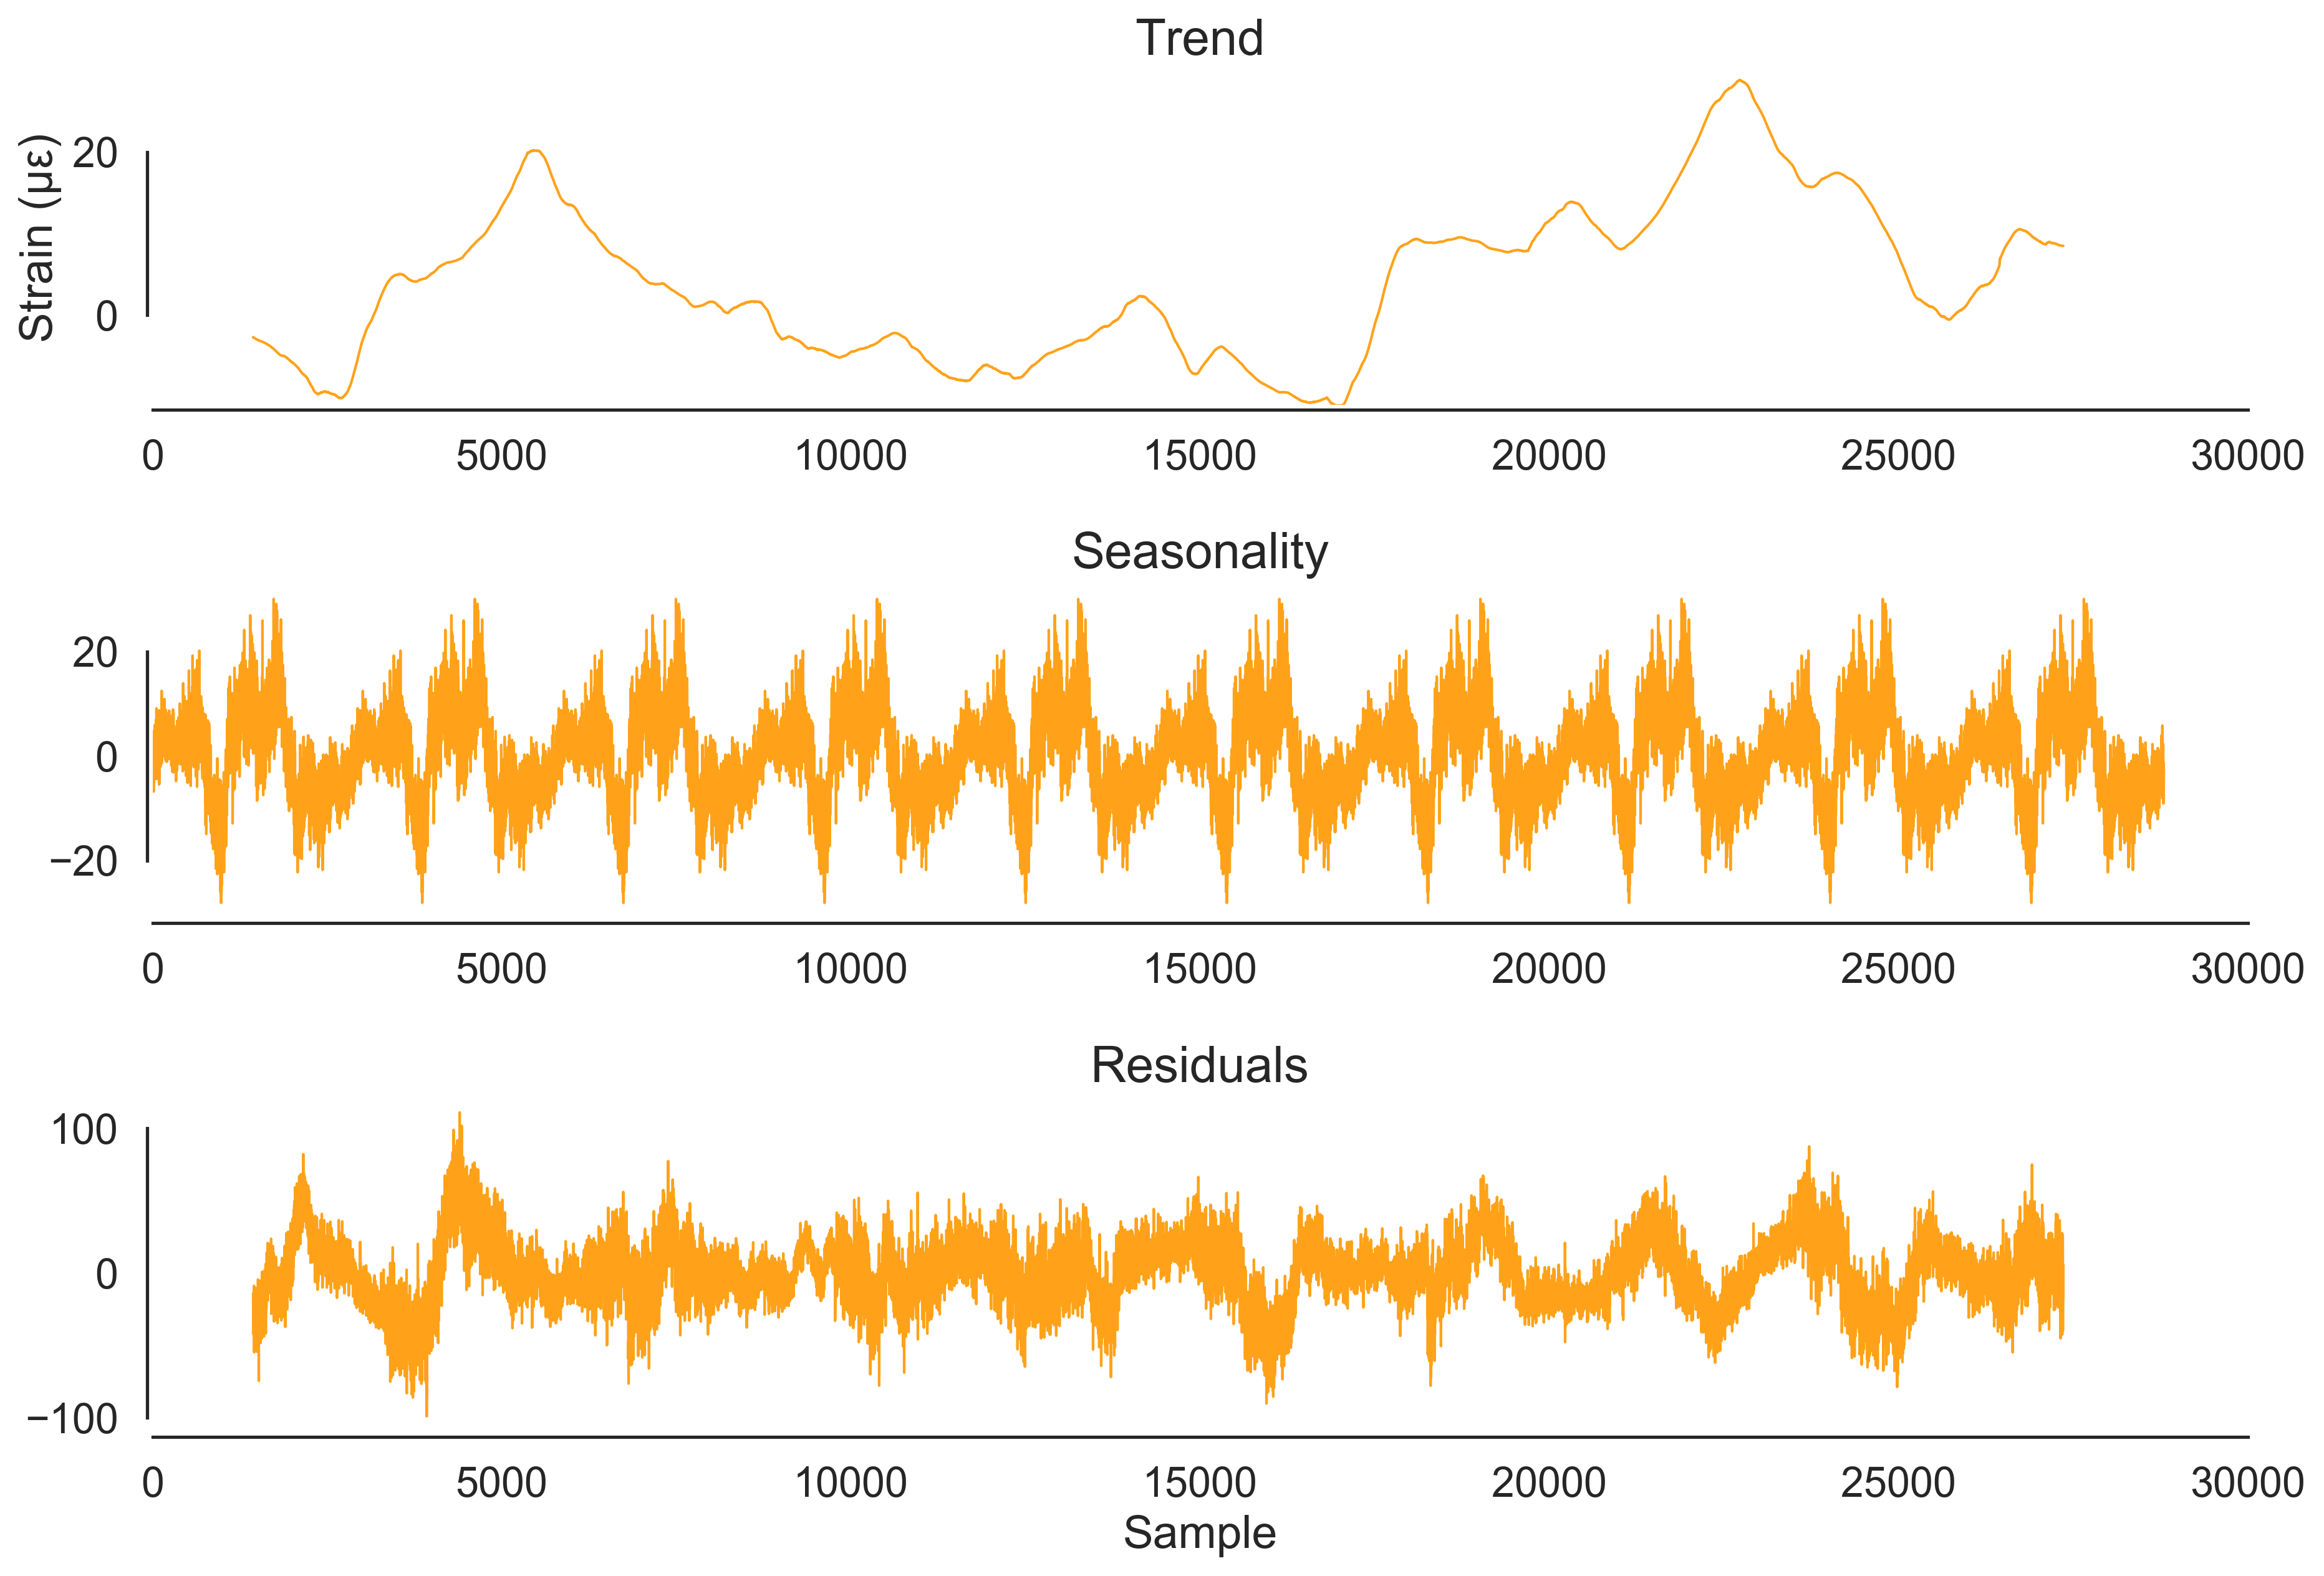

In [114]:
plt.figure(dpi=300)

plt.subplot(311)
plt.plot(trend, linewidth=1, alpha=0.9, color=c_orange)
plt.title('Trend')
plt.xlim(0, 30001)
plt.ylim(-11, 30)
plt.ylabel('Strain (µε)')
sns.despine(offset=2, trim=True)

plt.subplot(312)
plt.plot(seasonal, linewidth=1, alpha=0.9, color=c_orange)
plt.title('Seasonality')
plt.xlim(0, 30001)
sns.despine(offset=1, trim=True)

plt.subplot(313)
plt.plot(residual, linewidth=1, alpha=0.9, color=c_orange)
plt.title('Residuals')
plt.xlim(0, 30001)
plt.xlabel('Sample')
sns.despine(offset=2, trim=True)

plt.tight_layout()
plt.savefig('lstm-decompose.png')

In [142]:
from scipy.stats import skew

In [143]:
skew(residd)

7.016564987568043

In [171]:
mean = np.mean(residd)

median = np.median(residd)

std = np.std(residd)

In [172]:
np.logical_or(residd > (mean+std), residd < (mean-std)).sum()

6919

In [166]:
len(residd)

28800

In [182]:
residd

array([  5.38197917,   5.8937125 ,   5.08321458, ..., -18.17801563,
         7.4479375 ,  -9.30419167])

In [183]:
resid

0         5.381979
1         5.893713
2         5.083215
3         6.381738
4         2.509533
5         8.607910
6         3.598633
7         6.829227
8         3.143121
9         1.530494
10        0.547454
11       12.176773
12        0.266746
13        6.675135
14        3.109602
15        4.625010
16        6.044404
17        5.049133
18        9.372012
19        5.013640
20        5.057100
21        4.334531
22        8.400737
23        9.125131
24        1.506652
25        1.137425
26        1.695777
27        5.731715
28        1.069598
29        5.508719
           ...    
28770    11.215725
28771     0.145596
28772    11.263046
28773     0.974012
28774     3.740898
28775     5.469791
28776    10.351025
28777     3.338851
28778     6.388705
28779     9.552907
28780    10.744206
28781    16.372479
28782     0.272886
28783     5.232273
28784     4.692421
28785    13.929999
28786     0.481275
28787     5.931907
28788    12.270444
28789    19.911572
28790    27.483056
28791    12.

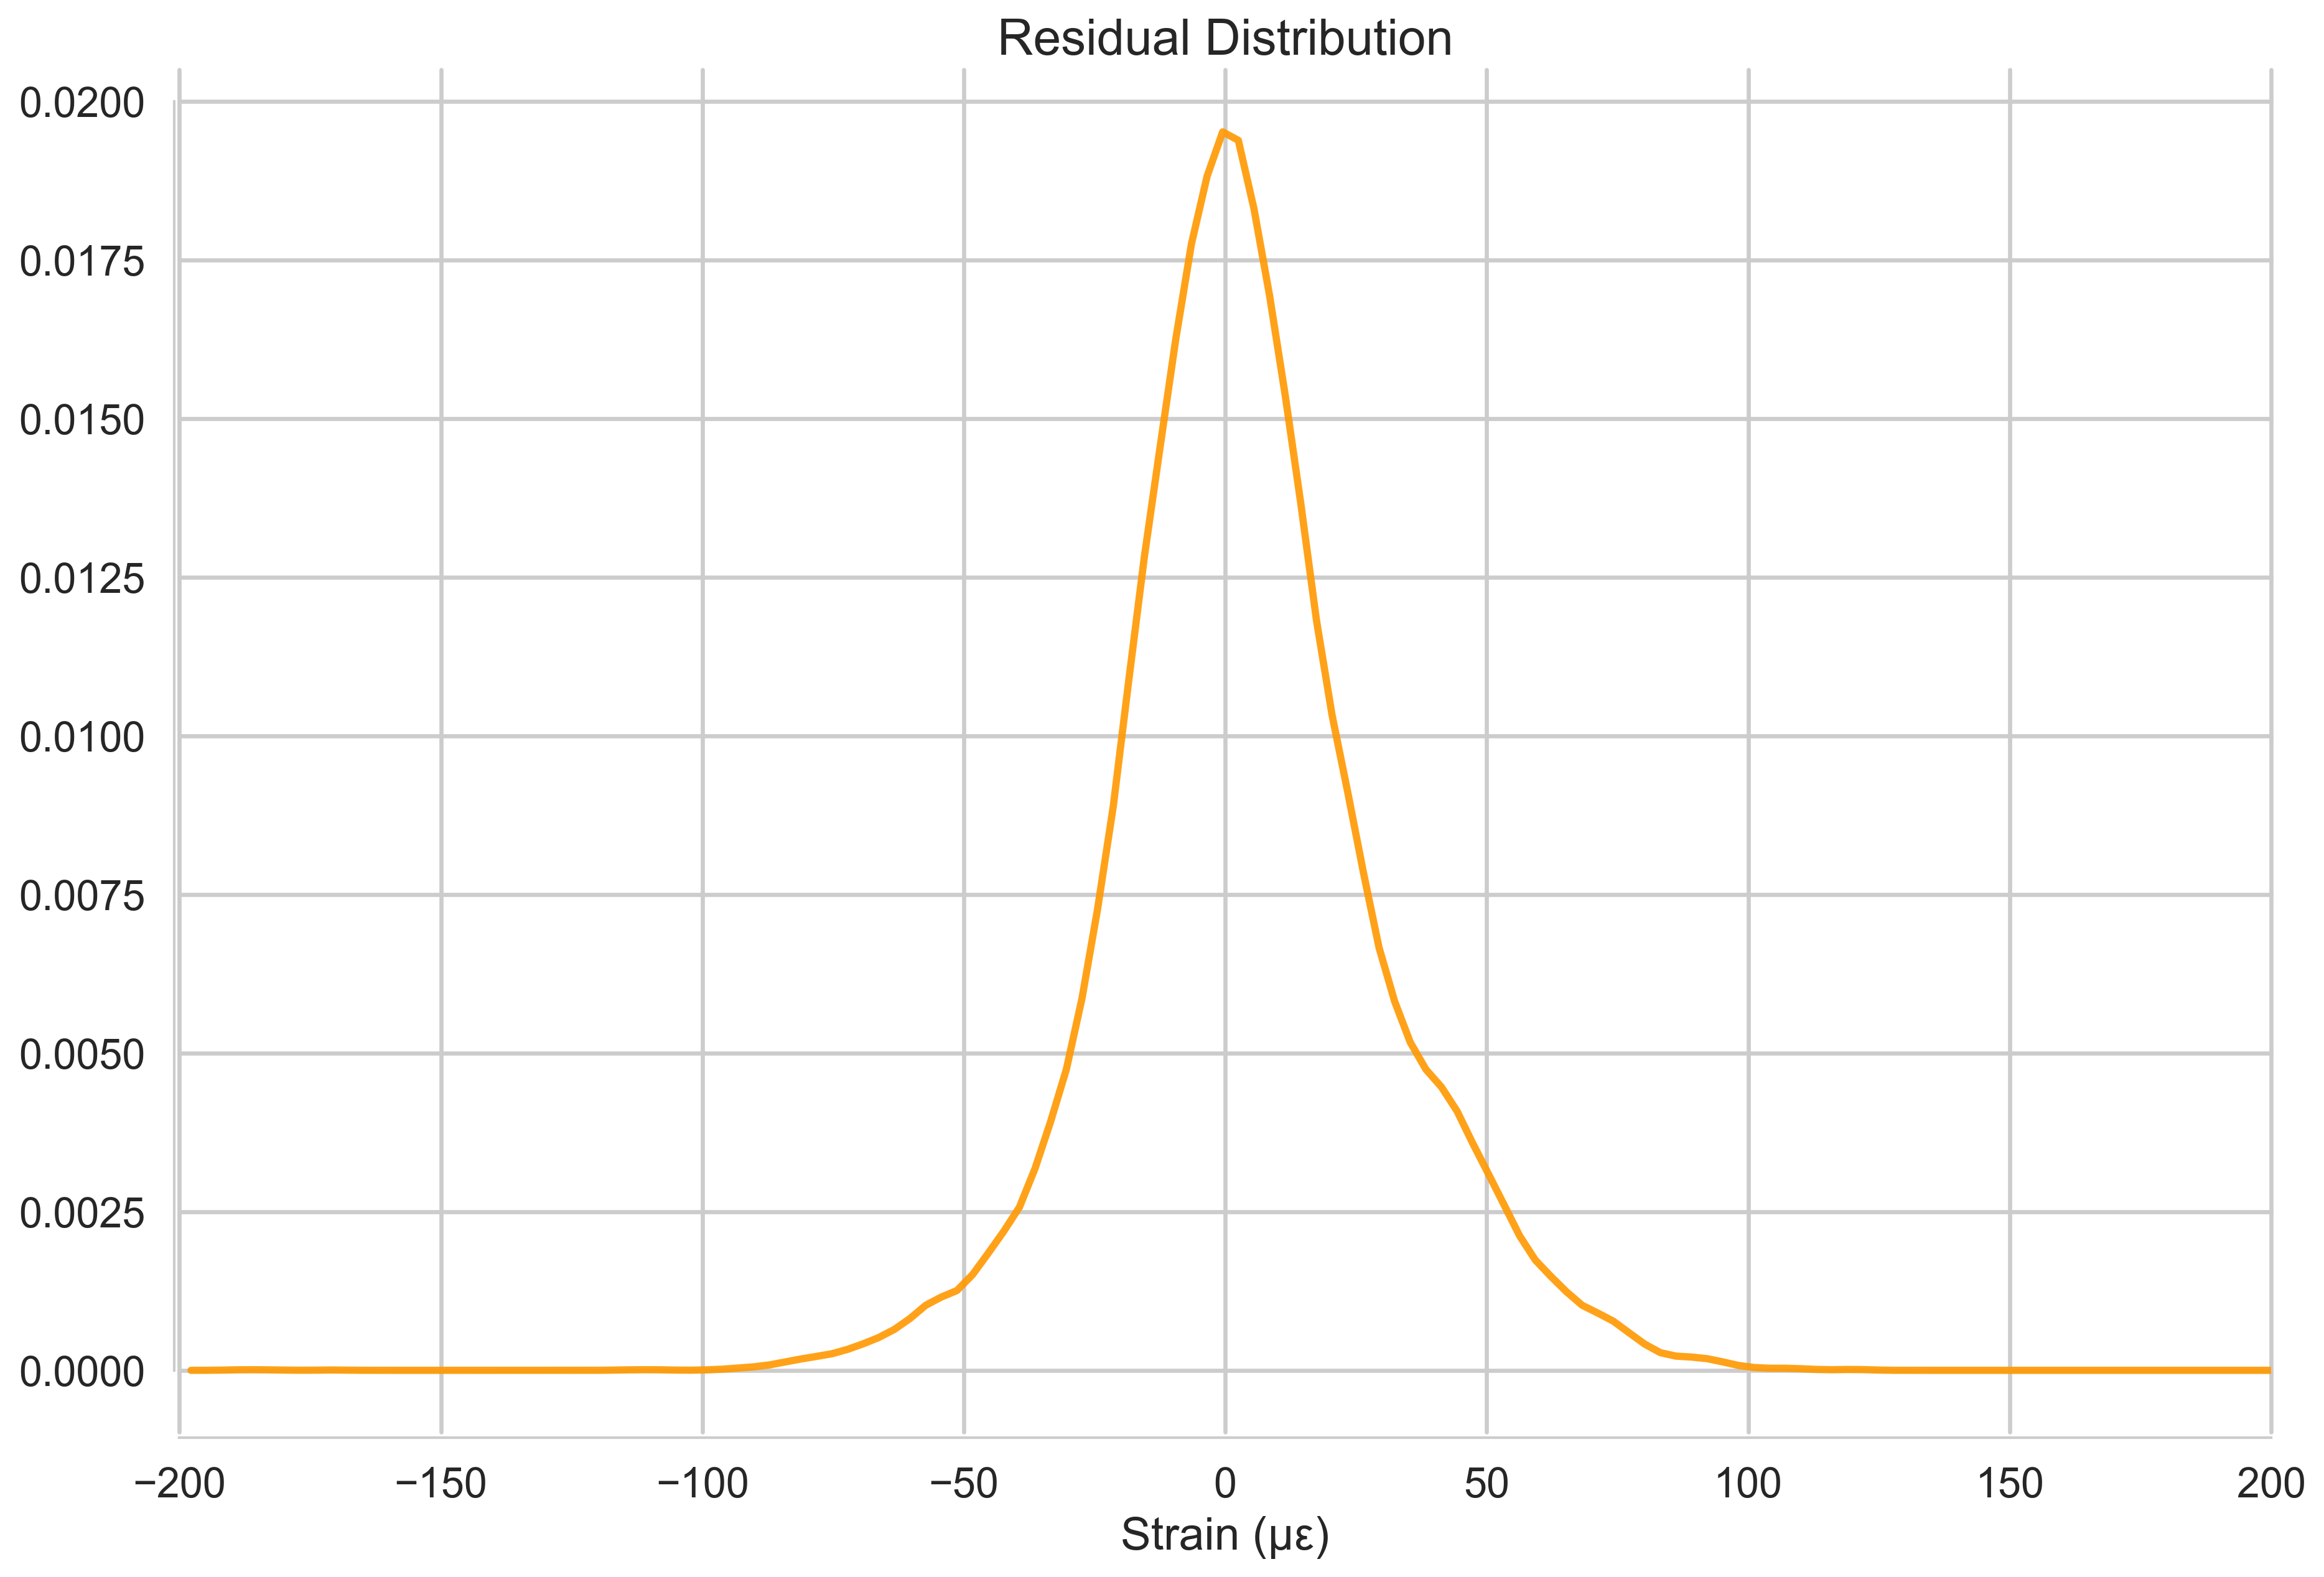

In [176]:
plt.figure(dpi=300)

sns.set_style('whitegrid')
sns.kdeplot(residd, gridsize=400, color=c_orange, alpha=0.9)

plt.xlim(-200, 200)
plt.xlabel('Strain (µε)')
plt.title('Residual Distribution')
plt.tight_layout()
sns.despine(offset=2, trim=True)
plt.savefig('LSTM-RESI-DIST.png')